/tmp/ipykernel_197781/3500717838.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_197781/3500717838.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


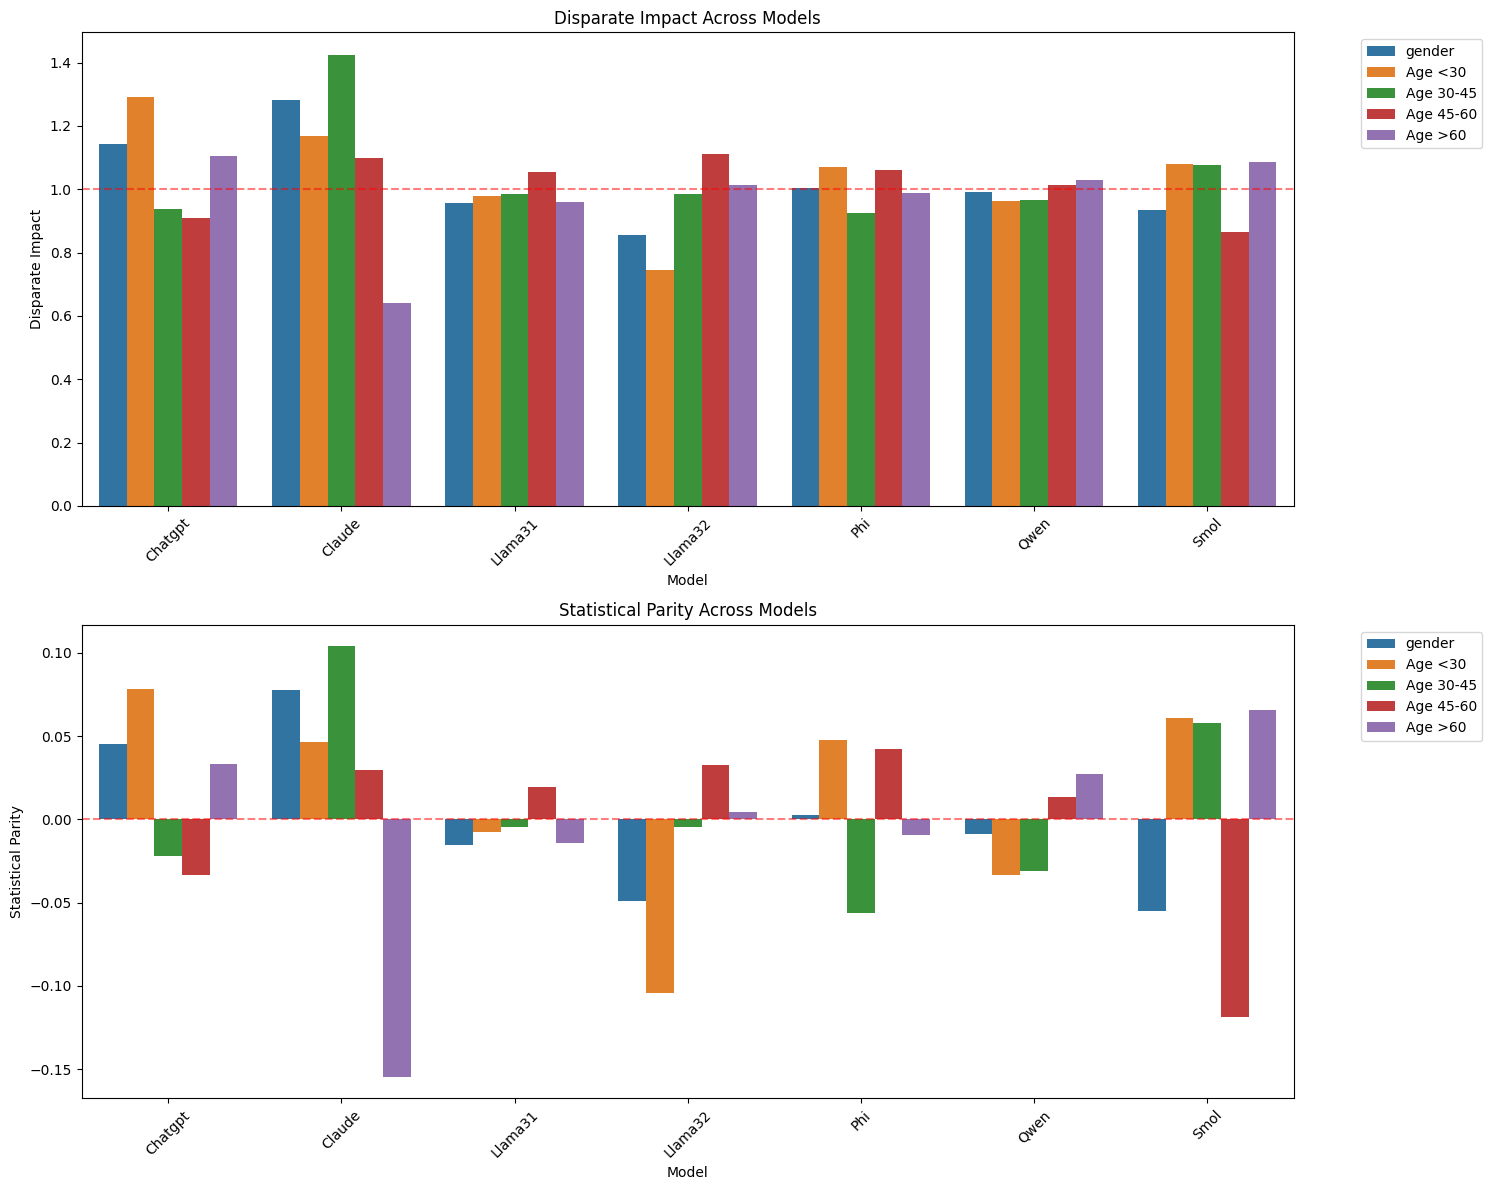


Summary Statistics:
          Disparate Impact           Statistical Parity          
                      mean       std               mean       std
Type                                                             
Age 30-45         1.043307  0.174911           0.006081  0.055545
Age 45-60         1.016473  0.094980          -0.002062  0.056920
Age <30           1.042596  0.172049           0.012423  0.064840
Age >60           0.974835  0.155625          -0.006892  0.070765
gender            1.023816  0.142934          -0.000424  0.048036

Prediction Distribution by Model:

chatgpt:
chatgpt_prediction
0.0    1107
1.0     574
NaN     116
Name: count, dtype: int64

claude:
claude_prediction
0.0    1141
1.0     536
NaN     120
Name: count, dtype: int64

llama31:
llama31_prediction
0.0    771
NaN    606
1.0    420
Name: count, dtype: int64

llama32:
llama32_prediction
NaN    869
0.0    636
1.0    292
Name: count, dtype: int64

phi:
phi_prediction
1.0    1210
0.0     469
NaN     118
Nam

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

def extract_demographics(prompt):
    """Extract age and gender from prompt text."""
    if not isinstance(prompt, str):
        return None, None
        
    import re
    age_match = re.search(r'(\d+)-year-old', prompt)
    gender_match = re.search(r'-year-old\s+(\w+)', prompt)
    
    age = int(age_match.group(1)) if age_match else None
    gender = gender_match.group(1).lower() if gender_match else None
    
    gender_binary = 1.0 if gender == 'male' else 0.0 if gender == 'female' else None
    
    if age is not None:
        age_group = pd.cut([age], bins=[0, 30, 45, 60, float('inf')], 
                          labels=['<30', '30-45', '45-60', '>60'])[0]
    else:
        age_group = None
        
    return gender_binary, age_group

def extract_model_prediction(response):
    """
    Extract fraud/genuine prediction from model response.
    Returns:
    - 1.0 for fraud
    - 0.0 for genuine
    - np.nan for unclear/not found
    """
    if pd.isna(response):
        return np.nan
    
    response = str(response).upper()
    if 'CONCLUSION: FRAUD' in response:
        return 1.0
    elif 'CONCLUSION: GENUINE' in response:
        return 0.0
    return np.nan

def process_model_predictions(df, model_responses):
    """
    Create separate columns for each model's prediction and add ground truth.
    """
    # Add ground truth from metadata
    df['ground_truth'] = df['Metadata'].apply(
        lambda x: 1.0 if isinstance(x, str) and 'True' in x else 0.0
    )
    
    # Process each model's predictions
    for model_col in model_responses:
        model_name = model_col.split('_')[0]
        prediction_col = f'{model_name}_prediction'
        df[prediction_col] = df[model_col].apply(extract_model_prediction)
    
    return df

def calculate_bias_metrics(df, protected_attr):
    """Calculate disparate impact and statistical parity."""
    try:
        dataset = BinaryLabelDataset(
            df=df,
            label_names=['label'],
            protected_attribute_names=[protected_attr],
            privileged_protected_attributes=[[1.0]]
        )
        
        metrics = BinaryLabelDatasetMetric(
            dataset,
            unprivileged_groups=[{protected_attr: 0.0}],
            privileged_groups=[{protected_attr: 1.0}]
        )
        
        return {
            'disparate_impact': metrics.disparate_impact(),
            'statistical_parity': metrics.statistical_parity_difference()
        }
    except:
        return {'disparate_impact': np.nan, 'statistical_parity': np.nan}

def analyze_model_bias(df, model_responses):
    """Analyze bias across different models and demographic groups."""
    # Extract demographics
    df['gender'], df['age_group'] = zip(*df['Prompt'].apply(extract_demographics))
    
    # Create age group indicators
    for group in ['<30', '30-45', '45-60', '>60']:
        df[f'age_{group}'] = (df['age_group'] == group).astype(float)
    
    # Process predictions and add ground truth
    df = process_model_predictions(df, model_responses)
    
    results = {}
    for model_col in model_responses:
        model_name = model_col.split('_')[0].capitalize()
        prediction_col = f'{model_name.lower()}_prediction'
        
        # Skip if prediction column doesn't exist
        if prediction_col not in df.columns:
            continue
            
        df_model = df.copy()
        df_model['label'] = df_model[prediction_col]
        
        # Analyze gender bias
        gender_bias = calculate_bias_metrics(
            df_model[['label', 'gender']].dropna(), 'gender'
        )
        
        # Analyze age group bias
        age_bias = {
            group: calculate_bias_metrics(
                df_model[['label', f'age_{group}']].dropna(), 
                f'age_{group}'
            )
            for group in ['<30', '30-45', '45-60', '>60']
        }
        
        results[model_name] = {'gender': gender_bias, **age_bias}
    
    return pd.DataFrame([
        {
            'Model': model,
            'Type': attr_type if attr_type == 'gender' else f'Age {attr_type}',
            'Disparate Impact': metrics['disparate_impact'],
            'Statistical Parity': metrics['statistical_parity']
        }
        for model, attrs in results.items()
        for attr_type, metrics in attrs.items()
    ])

def plot_bias_results(metrics_df):
    """Plot disparate impact and statistical parity metrics."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    for ax, metric in zip((ax1, ax2), ['Disparate Impact', 'Statistical Parity']):
        sns.barplot(data=metrics_df, x='Model', y=metric, hue='Type', ax=ax)
        ax.axhline(y=1 if metric == 'Disparate Impact' else 0, 
                   color='r', linestyle='--', alpha=0.5)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f'{metric} Across Models')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
model_responses = ['chatgpt_response', 'claude_response', 'llama31_response',
                  'llama32_response', 'phi_response', 'qwen_response', 'smol_response']

df = pd.read_csv('../../results/combined_model_responses_meta.ssv', sep=";")

# Process predictions and get metrics
df = process_model_predictions(df, model_responses)
metrics_df = analyze_model_bias(df, model_responses)

# Plot results
plot_bias_results(metrics_df)

# Print summary statistics
print("\nSummary Statistics:")
print(metrics_df.groupby('Type')[['Disparate Impact', 'Statistical Parity']]
      .agg(['mean', 'std']))

# Print prediction distribution for each model
print("\nPrediction Distribution by Model:")
for model_col in model_responses:
    model_name = model_col.split('_')[0]
    pred_col = f'{model_name}_prediction'
    if pred_col in df.columns:
        print(f"\n{model_name}:")
        print(df[pred_col].value_counts(dropna=False))

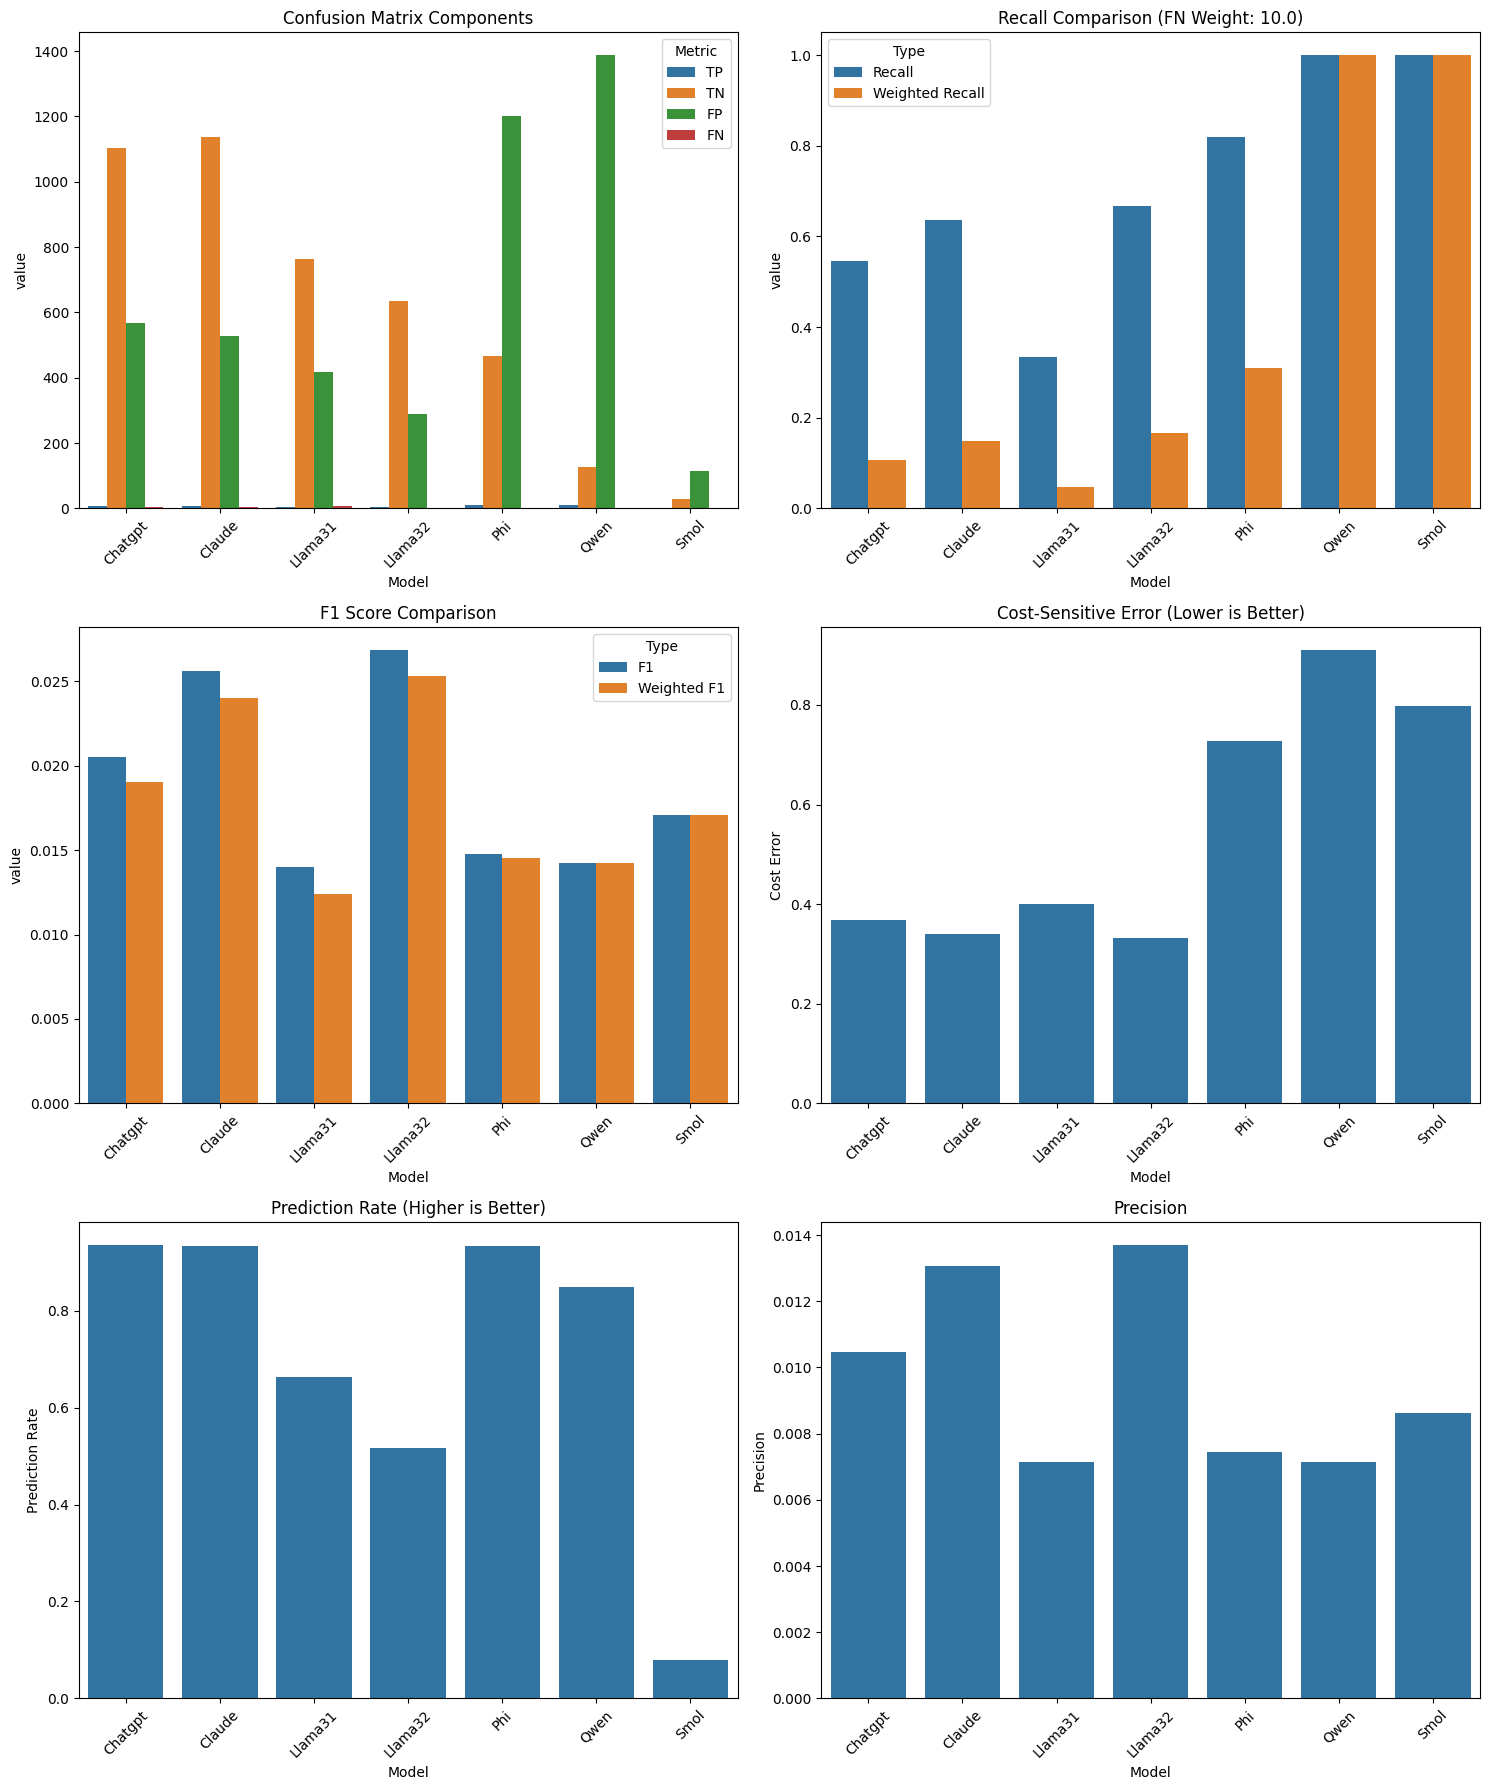

,Model,TP,TN,FP,FN,Precision,Recall,F1,Weighted Recall,Weighted F1,Cost Error,Prediction Rate
0,Chatgpt,6,1102,568,5,0.010453,0.545455,0.020513,0.107143,0.019048,0.367638,0.935448
1,Claude,7,1137,529,4,0.013060,0.636364,0.025594,0.148936,0.024014,0.339296,0.933222
2,Llama31,3,765,417,6,0.007143,0.333333,0.013986,0.047619,0.012422,0.400504,0.662771
3,Llama32,4,634,288,2,0.013699,0.666667,0.026846,0.166667,0.025316,0.331897,0.516416
4,Phi,9,467,1201,2,0.007438,0.818182,0.014742,0.310345,0.014528,0.727219,0.934335
5,Qwen,10,127,1388,0,0.007153,1.000000,0.014205,1.000000,0.014205,0.910164,0.848637
6,Smol,1,28,115,0,0.008621,1.000000,0.017094,1.000000,0.017094,0.798611,0.080134


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def analyze_model_performance(df, fn_weight=10.0):
    """
    Analyze model performance with weighted penalties for false negatives.
    
    Args:
        df: DataFrame with model predictions and ground truth
        fn_weight: Penalty weight for false negatives (default: 10.0)
    Returns:
        DataFrame with performance metrics for each model
    """
    # Get list of prediction columns (format: modelname_prediction)
    model_cols = [col for col in df.columns if col.endswith('_prediction')]
    results = []
    
    for col in model_cols:
        model_name = col.split('_')[0].title()
        
        # Get valid predictions (not NaN) and ground truth
        valid_mask = df[['ground_truth', col]].notna().all(axis=1)
        y_true = df.loc[valid_mask, 'ground_truth']
        y_pred = df.loc[valid_mask, col]
        
        if len(y_pred) > 0:
            # Calculate metrics
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true, y_pred, average='binary', zero_division=0
            )
            
            # Calculate weighted metrics
            weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
            weighted_f1 = (2 * precision * weighted_recall) / (precision + weighted_recall) \
                         if (precision + weighted_recall) > 0 else 0
            cost_error = (fp + fn_weight * fn) / len(y_pred)
            
            # Calculate prediction rate
            prediction_rate = len(y_pred) / len(df)
            
            results.append({
                'Model': model_name,
                'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Weighted Recall': weighted_recall,
                'Weighted F1': weighted_f1,
                'Cost Error': cost_error,
                'Prediction Rate': prediction_rate
            })
    
    return pd.DataFrame(results)

def plot_metrics(df, fn_weight=50.0):
    """
    Plot performance metrics for all models.
    
    Args:
        df: DataFrame with model predictions
        fn_weight: False negative penalty weight
    """
    metrics_df = analyze_model_performance(df, fn_weight)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    plt.style.use('default')  # Use default style instead of seaborn
    
    # Plot confusion matrix components
    confusion_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['TP', 'TN', 'FP', 'FN'],
        var_name='Metric'
    )
    sns.barplot(data=confusion_data, x='Model', y='value', hue='Metric', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix Components')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot recall comparison
    recall_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['Recall', 'Weighted Recall'],
        var_name='Type'
    )
    sns.barplot(data=recall_data, x='Model', y='value', hue='Type', ax=axes[0,1])
    axes[0,1].set_title(f'Recall Comparison (FN Weight: {fn_weight})')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot F1 comparison
    f1_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['F1', 'Weighted F1'],
        var_name='Type'
    )
    sns.barplot(data=f1_data, x='Model', y='value', hue='Type', ax=axes[1,0])
    axes[1,0].set_title('F1 Score Comparison')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot cost error
    sns.barplot(data=metrics_df, x='Model', y='Cost Error', ax=axes[1,1])
    axes[1,1].set_title('Cost-Sensitive Error (Lower is Better)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Plot prediction rate
    sns.barplot(data=metrics_df, x='Model', y='Prediction Rate', ax=axes[2,0])
    axes[2,0].set_title('Prediction Rate (Higher is Better)')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Plot precision
    sns.barplot(data=metrics_df, x='Model', y='Precision', ax=axes[2,1])
    axes[2,1].set_title('Precision')
    axes[2,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Example usage:
def run_performance_analysis(df, model_responses, fn_weight=50.0):
    """
    Run complete performance analysis pipeline.
    
    Args:
        df: Raw DataFrame with model responses
        model_responses: List of model response column names
        fn_weight: False negative penalty weight
    """
    # First process the predictions using functions from the previous code
    df = process_model_predictions(df, model_responses)
    
    # Then run performance analysis
    metrics_df = plot_metrics(df, fn_weight)
    
    # Display formatted metrics
    display(metrics_df.style
           .format({col: "{:.3f}" for col in metrics_df.columns if col != 'Model'})
           .background_gradient(subset=['Cost Error'], cmap='RdYlGn_r')
           .background_gradient(subset=['F1', 'Weighted F1', 'Prediction Rate'], cmap='RdYlGn'))
    
    return metrics_df

plot_metrics(df)